In [87]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read,write
from ase import Atoms
from ase.build import mx2, molecule
from ase.constraints import FixAtoms
from ase.visualize import view
from ase.calculators.espresso import Espresso, EspressoProfile
from ase.io.espresso import read_espresso_out
from ase.optimize import QuasiNewton
from ase.visualize import view

import time
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal,eV

from copy import deepcopy

In [2]:
# Source all important path for LIB and excutable path.
import os
os.environ['LD_LIBRARY_PATH'] ="/opt/packages/oneapi/v2023.2.0/mkl/2023.2.0/lib/intel64:/opt/packages/oneapi/v2023.2.0/compiler/2023.2.1/linux/lib:/opt/packages/oneapi/v2023.2.0/compiler/2023.2.1/linux/lib/x64:/opt/packages/oneapi/v2023.2.0/compiler/2023.2.1/linux/compiler/lib/intel64_lin:/opt/packages/oneapi/v2023.2.0/tbb/2021.10.0/lib/intel64/gcc4.8:/opt/packages/oneapi/v2023.2.0/mpi/2021.10.0/libfabric/lib:/opt/packages/oneapi/v2023.2.0/mpi/2021.10.0/lib/release:/opt/packages/oneapi/v2023.2.0/mpi/2021.10.0/lib"
os.environ['PATH'] ="/opt/packages/oneapi/v2023.2.0/mpi/2021.10.0/libfabric/bin:/opt/packages/oneapi/v2023.2.0/mpi/2021.10.0/bin:/opt/packages/psc.allocations.user/bin:/opt/packages/allocations/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/packages/interact/bin:/opt/puppetlabs/bin:/ocean/projects/che240027p/shared/software/Team_BSU_Soft/q-e/bin"


In [3]:
## Load the crystal structure (Crystallography Open Database) from local file
RuO2_bulk = read("./structure/RuO2.cif")
view(RuO2_bulk, viewer="x3d")

/ocean/projects/che240027p/shared/software/Team_BSU_Soft/qms2024-BSU/lib/python3.8/site-packages/ase/io/cif.py:408: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(136, setting=1). This may result in wrong setting!
  warnings.warn(


In [4]:
# Define basic commands and pseudodir
runprefix = "mpirun -np 32 "
qepath = " "
pseudodir = "./pseudos"

# Optionally create profile to override paths in ASE configuration:
profile = EspressoProfile(
    command=runprefix+qepath+'pw.x', pseudo_dir=pseudodir
)

In [5]:
# Download the pseudopotentials for Ru and O
!wget https://www.physics.rutgers.edu/gbrv/ru_pbesol_v1.2.uspp.F.UPF
!wget https://www.physics.rutgers.edu/gbrv/o_pbesol_v1.2.uspp.F.UPF
!mv *.F.UPF pseudos

pseudopotentials = {
    "O":"o_pbesol_v1.2.uspp.F.UPF",
    "Ru":"ru_pbesol_v1.2.uspp.F.UPF"
}

--2024-06-27 15:22:49--  https://www.physics.rutgers.edu/gbrv/ru_pbesol_v1.2.uspp.F.UPF
Resolving www.physics.rutgers.edu (www.physics.rutgers.edu)... 165.230.19.181
Connecting to www.physics.rutgers.edu (www.physics.rutgers.edu)|165.230.19.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 680601 (665K)
Saving to: ‘ru_pbesol_v1.2.uspp.F.UPF’

ru_pbesol_v1.2.uspp 100%[===================>] 664.65K  --.-KB/s    in 0.06s   

2024-06-27 15:22:49 (11.2 MB/s) - ‘ru_pbesol_v1.2.uspp.F.UPF’ saved [680601/680601]

--2024-06-27 15:22:49--  https://www.physics.rutgers.edu/gbrv/o_pbesol_v1.2.uspp.F.UPF
Resolving www.physics.rutgers.edu (www.physics.rutgers.edu)... 165.230.19.181
Connecting to www.physics.rutgers.edu (www.physics.rutgers.edu)|165.230.19.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 376736 (368K)
Saving to: ‘o_pbesol_v1.2.uspp.F.UPF’

o_pbesol_v1.2.uspp. 100%[===================>] 367.91K  --.-KB/s    in 0.05s   

2024-06-2

## Optimized K-points

Here the convergence of K-points are tested. Currently Ecut_wfc = 50, Ecut_rho = 400

In [14]:
Ecut_wfc = 50
Ecut_rho = Ecut_wfc*8
K_num = 1
input_data = {
    'control': {
        'restart_mode': 'from_scratch',
        'pseudo_dir': './pseudos',
        'calculation': 'scf',
        'prefix': 'RuO2'
    },
    'system': {
        'ecutwfc': Ecut_wfc,
        'ecutrho': Ecut_rho,
        'occupations':'smearing',
        'smearing':'gauss',
        'degauss': 0.01,
        'nspin': 2,
        'starting_magnetization(2)' : 0.5
    },
    'electrons': {
        'conv_thr': 1.0e-8, 
        'mixing_beta': 0.7
    },
} 




In [15]:
# K points = 1,2,4,8,16,18,20,24
K_conv = []
for k in [1,2,4,8,16,18,20,24]:
    # Update the k value in calculator
    calc = Espresso(
        profile=profile,
        pseudopotentials=pseudopotentials,
        tstress=True,  # deprecated, put in input_data
        tprnfor=True,  # deprecated, put in input_data
        input_data=input_data,
        kpts=(k,k,k),
        koffset=(0,0,0))
    
    
    RuO2_bulk.calc = deepcopy(calc)
    
    eRuO2_bulk = RuO2_bulk.get_potential_energy()
    K_conv.append([k, eRuO2_bulk])
    if os.path.isfile("espresso.pwo"): os.remove("espresso.pwo")
    print(f'{k}: {eRuO2_bulk:.8f}')

1: -7036.61596064
2: -7038.62906208
4: -7038.32100472
8: -7038.31158156
16: -7038.31142958
18: -7038.31145911
20: -7038.31143951
24: -7038.31144509


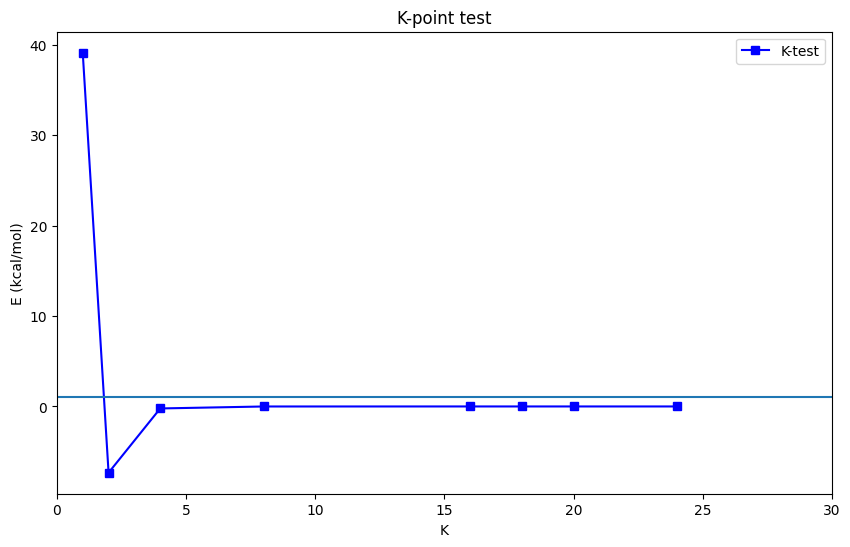

In [17]:
K_conv = np.array(K_conv)
# Create a figure and a set of subplots
fig, ax = plt.subplots( figsize=(10, 6))

# Plot sine wave
ax.plot(K_conv[:,0], (K_conv[:,1]-K_conv[-1,1])*mol/kcal,'-s', label='K-test', color='blue')

ax.hlines(1,xmin=-1,xmax=30)
ax.set_xlim(0,30)
ax.set_title('K-point test')
ax.set_xlabel('K')
ax.set_ylabel('E (kcal/mol)')
ax.legend()

K-points (4,4,4) is good. 

## Optimize the Ecut_wfc with (Ecut_rho = Ecut_wfc*8)

In [9]:
input_data = {
    'control': {
        'restart_mode': 'from_scratch',
        'pseudo_dir': './pseudos',
        'calculation': 'scf',
        'prefix': 'RuO2'
    },
    'system': {
        'ecutwfc': 50,
        'ecutrho': 400,
        'occupations':'smearing',
        'smearing':'gauss',
        'degauss': 0.01,
        'nspin': 2,
        'starting_magnetization(2)' : 0.5

    },
    'electrons': {
        'conv_thr': 1.0e-8, 
        'mixing_beta': 0.7
    },
}


E_wfc2 =[] 
for Ecut_wfc in [20,25,30,35,40,45,50,55,60,70,80,90,100]:
    
    input_data['system']['ecutwfc'] = Ecut_wfc
    input_data['system']['ecutrho'] = Ecut_wfc*8
    calc = Espresso(
        profile=profile,
        pseudopotentials=pseudopotentials,
        tstress=True,  # deprecated, put in input_data
        tprnfor=True,  # deprecated, put in input_data
        input_data=input_data,
        kpts=(4,4,4),
        koffset=(0,0,0))
    
    RuO2_bulk.calc = deepcopy(calc)
    
    
    eRuO2_bulk = RuO2_bulk.get_potential_energy()
    #if os.path.isfile("espresso.pwo"): os.remove("espresso.pwo")
    print(f'{Ecut_wfc}: {eRuO2_bulk:.8f}')
    E_wfc2.append([Ecut_wfc,eRuO2_bulk])



20: -7011.05568545
25: -7032.91024948
30: -7037.56432730
35: -7038.22458336
40: -7038.28885393
45: -7038.30336685
50: -7038.32100472
55: -7038.33684624
60: -7038.34679540
70: -7038.35244081
80: -7038.35852555
90: -7038.36928248
100: -7038.37577280


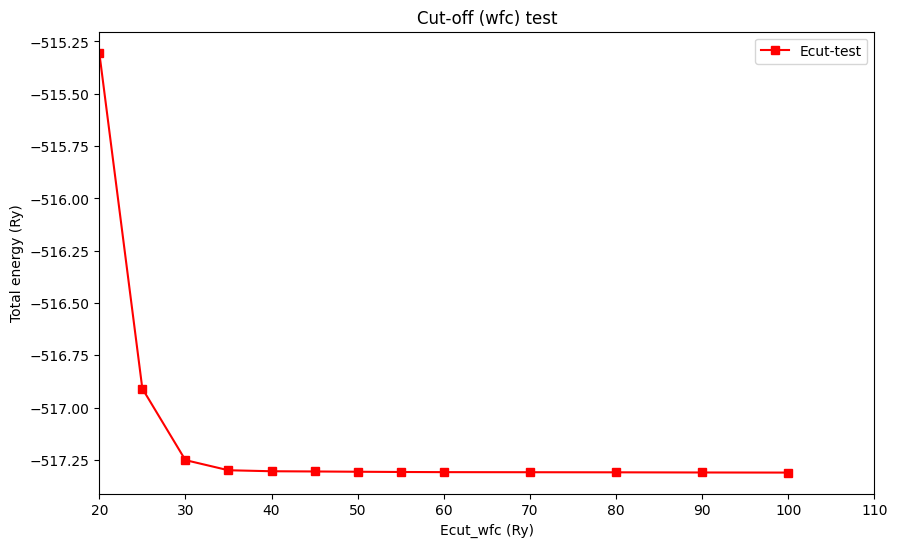

In [12]:
E_wfc2 = np.array(E_wfc2)
#K_conv = np.array(K_conv)
# Create a figure and a set of subplots
fig, ax = plt.subplots( figsize=(10, 6))

# Plot sine wave
#ax.plot(E_wfc[:,0], E_wfc[:,1]-E_wfc[-1,1],'-s', label='Ecut-test', color='blue')
ax.plot(E_wfc2[:,0], E_wfc2[:,1]/Rydberg,'-s', label='Ecut-test', color='red')


ax.set_xlim(20,110)
#ax.set_ylim(-1,4)
ax.set_title('Cut-off (wfc) test')
ax.set_xlabel('Ecut_wfc (Ry)')
ax.set_ylabel(r'Total energy (Ry)')
ax.legend()

In [145]:
for i,j,k in zip(E_wfc2[:,0], E_wfc2[:,1],E_wfc2[:,1]-np.roll(E_wfc2[:,1],1)):
    print(i, j, k/4)

20.0 -7011.055730072685 6.830022077500416
25.0 -7032.910295060395 -5.463641246927409
30.0 -7037.56437301102 -1.163519487656231
35.0 -7038.224629076734 -0.16506401642868695
40.0 -7038.288899644286 -0.016067641887957507
45.0 -7038.303412563758 -0.0036282298678997904
50.0 -7038.321050302494 -0.004409434684021107
55.0 -7038.33689195384 -0.0039604128364771896
60.0 -7038.346841116065 -0.00248729055624608
70.0 -7038.352486525819 -0.0014113524384811171
80.0 -7038.358571263365 -0.0015211843865472474
90.0 -7038.369328195522 -0.002689233039291139
100.0 -7038.375818382687 -0.0016225467911681335


## Optimize the Ecut_rho with Ecut_wfc = 40

In [31]:
input_data = {
    'control': {
        'restart_mode': 'from_scratch',
        'pseudo_dir': './pseudos',
        'outdir': 'RuO2_out',
        'calculation': 'scf',
        'prefix': 'RuO2'
    },
    'system': {
        'ecutwfc': 40,
        'ecutrho': 320,
        'occupations':'smearing',
        'smearing':'gauss',
        'degauss': 0.01,
        'nspin': 2,
        'starting_magnetization(2)' : 0.5
    },
    'electrons': {
        'conv_thr': 1.0e-8, 
        'mixing_beta': 0.7
    },
}


E_rho =[] 
Ecut_wfc = 40
for alpha in [3,4,5,6,7, 8, 9, 10, 11, 12, 13]:
    
    input_data['system']['ecutwfc'] = Ecut_wfc
    input_data['system']['ecutrho'] = Ecut_wfc*alpha
    calc = Espresso(
        profile=profile,
        pseudopotentials=pseudopotentials,
        tstress=True,  # deprecated, put in input_data
        tprnfor=True,  # deprecated, put in input_data
        input_data=input_data,
        kpts=(4,4,4),
        koffset=(0,0,0))
    
    RuO2_bulk.calc = deepcopy(calc)
    
    
    eRuO2_bulk = RuO2_bulk.get_potential_energy()
    #if os.path.isfile("espresso.pwo"): os.remove("espresso.pwo")
    print(f'{alpha}: {eRuO2_bulk:.8f}')
    E_rho.append([alpha,eRuO2_bulk])



3: -7038.29425199
4: -7038.28849351
5: -7038.28848943
6: -7038.28875080
7: -7038.28869678
8: -7038.28885393
9: -7038.28898631
10: -7038.28885924
11: -7038.28901543
12: -7038.28898740
13: -7038.28890822


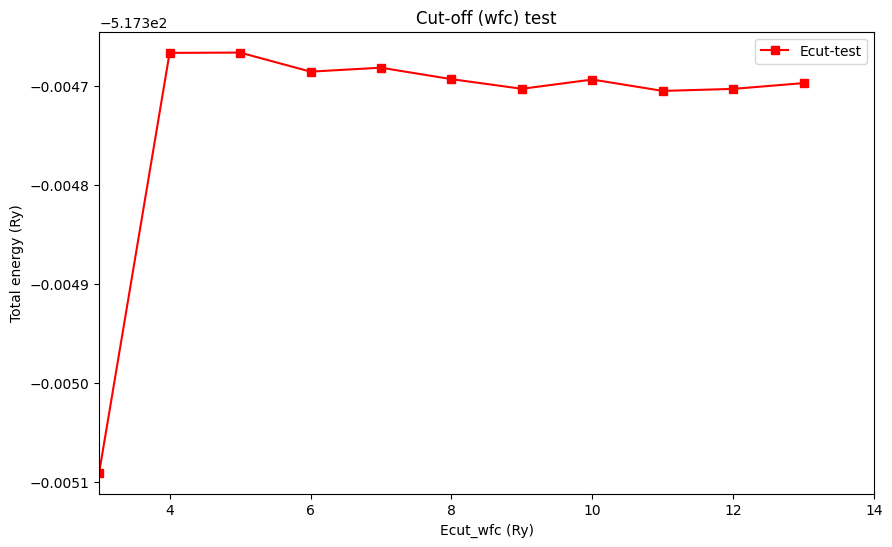

In [19]:
E_rho = np.array(E_rho)
# Create a figure and a set of subplots
fig, ax = plt.subplots( figsize=(10, 6))

# Plot sine wave
ax.plot(E_rho[:,0], E_rho[:,1]/Rydberg,'-s', label='Ecut-test', color='red')

#ax._set_offset(0)

ax.set_xlim(3,14)
#ax.set_ylim(-1,4)
ax.set_title('Cut-off (wfc) test')
ax.set_xlabel('Ecut_wfc (Ry)')
ax.set_ylabel(r'Total energy (Ry)')
ax.legend()

## Hubbard U (Ph.x) Doesn't work

In [66]:
# Do a SCF calculation

input_data = {
    'control': {
        'restart_mode': 'from_scratch',
        'pseudo_dir': './pseudos',
        'outdir': 'RuO2_out',
        'calculation': 'scf',
        'prefix': 'RuO2'
    },
    'system': {
        'ecutwfc': 40,
        'ecutrho': 320,
        'occupations':'smearing',
        'smearing':'gauss',
        'degauss': 0.01
    },
    'electrons': {
        'conv_thr': 1.0e-8, 
        'mixing_beta': 0.7
    },
}


additional_cards = ['HUBBARD (ortho-atomic)', 'U Ru-4d 5.0']

write(
    'espresso.pwi',
    RuO2_bulk,
    input_data=input_data,
    pseudopotentials=pseudopotentials,
    additional_cards=additional_cards,   
    tstress=True,  # deprecated, put in input_data
    tprnfor=True,  # deprecated, put in input_data
    format='espresso-in',    
    kpts=(4,4,4),
    koffset=(0,0,0)
)

#eRuO2_bulk = RuO2_bulk.get_potential_energy()

In [71]:
!mpirun -np 32 pw.x <espresso.pwi >espresso.pwo

In [75]:
# prepare the ph imput file

from ase.io.espresso import write_espresso_ph, read_espresso_ph

input_data = {
  'tr2_ph': 1.0e-12,
  'prefix':'RuO2',
  'outdir': 'RuO2_out/RuO2.save',
  'verbosity': 'high',
  'ldisp': True,
  'qplot': False,
  'nq1': 4,
  'nq2' : 4,
  'nq3' : 4,
  'alpha_mix(1)': 0.1,
}
qpts = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0), (0.0, 0.0, 0.5)]
fd_ph = open('input_ph.in', "w+")
write_espresso_ph(fd_ph, input_data,qpts=qpts)
fd_ph.close()

In [78]:
!mpirun -np 32 hp.x <input_ph.in >ph.out

Abort(1) on node 20 (rank 20 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 1) - process 20
Abort(1) on node 24 (rank 24 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 1) - process 24
Abort(1) on node 28 (rank 28 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 1) - process 28
Abort(1) on node 30 (rank 30 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 1) - process 30
Abort(1) on node 31 (rank 31 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 1) - process 31


## U value fit (linear,Kulik)

In [56]:
# Do a SCF calculation

input_data = {
    'control': {
        'restart_mode': 'from_scratch',
        'pseudo_dir': './pseudos',
        'outdir': 'RuO2_out',
        'calculation': 'scf',
        'prefix': 'RuO2'
    },
    'system': {
        'ecutwfc': 40,
        'ecutrho': 320,
        'occupations':'smearing',
        'smearing':'gauss',
        'degauss': 0.01,
        'Hubbard_alpha(1)': -0.02
    },
    'electrons': {
        'conv_thr': 1.0e-8, 
        'mixing_beta': 0.7,
        'startingpot':"file" 
    },
}

additional_cards = ['HUBBARD (ortho-atomic)', 'U Ru-4d 0.000000000001']
input_data['system']['Hubbard_alpha(1)'] =  0.00000000000001
input_data['control']['prefix'] =  'RuO2_o'

write(
    'espresso.pwi',
    RuO2_bulk,
    input_data=input_data,
    pseudopotentials=pseudopotentials,
    additional_cards=additional_cards,   
    tstress=True,  # deprecated, put in input_data
    tprnfor=True,  # deprecated, put in input_data
    format='espresso-in',    
    kpts=(4,4,4),
    koffset=(0,0,0)
)
# Have to be in commandline Computer the 0 alpha

run_cmd = f"mpirun -np 32 pw.x <espresso.pwi > espresso0.pwo"
os.system(run_cmd)

Chi_0 =[]
Chi_r =[]
# Have to be in Scan the alpha for -0.1 to 1
Tag = 1
for alpha in [-0.1,-0.08,-0.06,-0.04,-0.02, 0.02, 0.04, 0.06, 0.08, 0.1]:
    input_data['system']['Hubbard_alpha(1)'] =  alpha
    input_data['control']['prefix'] =  f'RuO2_{Tag}'
    
    # Copy zero alpha to current dir. 
    os.system(f'cp -rf ./RuO2_out/RuO2_o.save ./RuO2_out/RuO2_{Tag}.save')
    write(
        'espresso.pwi',
        RuO2_bulk,
        input_data=input_data,
        pseudopotentials=pseudopotentials,
        additional_cards=additional_cards,   
        tstress=True,  # deprecated, put in input_data
        tprnfor=True,  # deprecated, put in input_data
        format='espresso-in',    
        kpts=(4,4,4),
        koffset=(0,0,0)
    )
    # Have to be in commandline
    run_cmd = f"mpirun -np 32 pw.x <espresso.pwi > espresso{Tag}.pwo"
    #os.system(run_cmd)
    
    # Read the Occupation
    fileOut = open(f"espresso{Tag}.pwo",'r').readlines()
    matched_strings = [s for s in fileOut if "Number of occupied Hubbard levels" in s]
    print(matched_strings[1].strip().split()[-1], matched_strings[2].strip().split()[-1])
    Chi_0.append([alpha, float(matched_strings[1].strip().split()[-1])])
    Chi_r.append([alpha, float(matched_strings[2].strip().split()[-1])])
    Tag = Tag+1


12.5875 12.5459
12.5740 12.5408
12.5606 12.5356
12.5472 12.5305
12.5338 12.5253
12.5072 12.5149
12.4939 12.5097
12.4807 12.5045
12.4675 12.4994
12.4543 12.4943


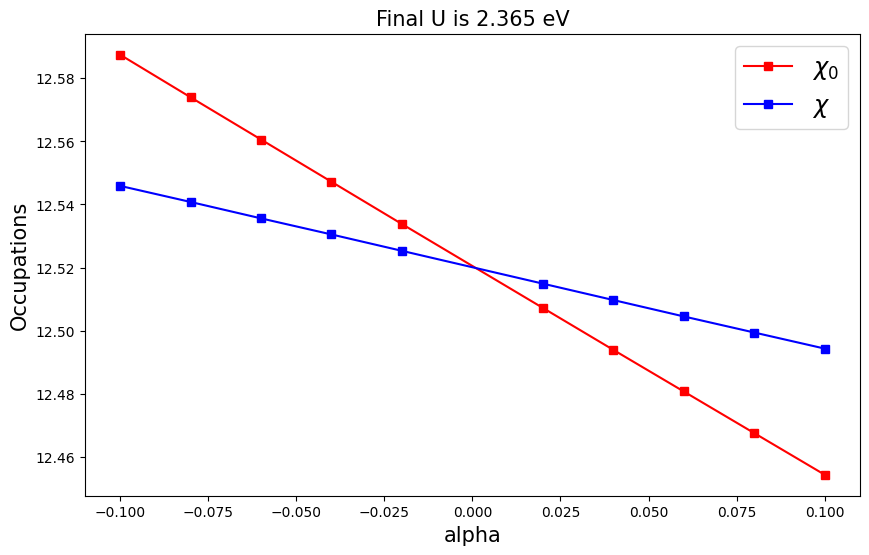

In [80]:
Chi_0 = np.array(Chi_0)
Chi_r = np.array(Chi_r)

fig, ax = plt.subplots( figsize=(10, 6))

# Plot sine wave
ax.plot(Chi_0[:,0], Chi_0[:,1],'-s', label=r'$\chi_0$', color='red')
ax.plot(Chi_r[:,0], Chi_r[:,1],'-s', label=r'$\chi$', color='blue')

m_0, b_0 = np.polyfit(Chi_0[:,0], Chi_0[:,1], 1)
m_r, b_r = np.polyfit(Chi_r[:,0], Chi_r[:,1], 1)

ax.set_title(f'Final U is {1/m_0-1/m_r:.3f} eV',fontsize=15)
ax.set_xlabel('alpha',fontsize=15)
ax.set_ylabel(r'Occupations',fontsize=15)
ax.legend(fontsize="xx-large")

## Optimization

In [104]:
# Do a SCF calculation

input_data = {
    'control': {
        'restart_mode': 'from_scratch',
        'pseudo_dir': './pseudos',
        'outdir': 'RuO2_out',
        'calculation': 'vc-relax',
        'prefix': 'RuO2_o'
    },
    'system': {
        'ecutwfc': 50,
        'ecutrho': 400,
        'occupations':'smearing',
        'smearing':'gauss',
        'degauss': 0.01,
        'Hubbard_alpha(1)': -0.02
    },
    'electrons': {
        'conv_thr': 1.0e-8, 
        'mixing_beta': 0.7,
        'startingpot':"file" 
    },
}

additional_cards = ['HUBBARD (ortho-atomic)', 'U Ru-4d 2.365']

write(
    'espresso_opt.pwi',
    RuO2_bulk,
    input_data=input_data,
    pseudopotentials=pseudopotentials,
    additional_cards=additional_cards,   
    tstress=True,  # deprecated, put in input_data
    tprnfor=True,  # deprecated, put in input_data
    format='espresso-in',    
    kpts=(8,8,8),
    koffset=(0,0,0)
)
# Have to be in commandline Computer the 0 alpha

run_cmd = f"mpirun -np 32 pw.x <espresso_opt.pwi > espresso_opt.pwo"
os.system(run_cmd)

0

In [ ]:
#Doesn't work 

#Relaxed_RuO2 = read("espresso_opt.pwo",format='espresso-out')

In [103]:
#OPT results
'''
CELL_PARAMETERS (angstrom)
   4.466042647   0.000000000   0.000000000
   0.000000000   4.466042647   0.000000000
   0.000000000   0.000000000   3.101366089

ATOMIC_POSITIONS (angstrom)
Ru               0.0000000000        0.0000000000        0.0000000000
Ru               2.2330213233        2.2330213233        1.5506830443
O                1.3601491182        1.3601491182        0.0000000000
O                3.1058935284        3.1058935284        0.0000000000
O                3.5931704414        0.8728722051        1.5506830443
O                0.8728722051        3.5931704414        1.5506830443
End final coordinates
density =      7.14421 g/cm^3
Total force =     0.000083     Total SCF correction =     0.000003
'''

print(RuO2_bulk.positions)
print(RuO2_bulk.cell)

[[0.         0.         0.        ]
 [2.2484     2.2484     1.55245   ]
 [1.37287304 1.37287304 0.        ]
 [3.12392696 3.12392696 0.        ]
 [3.62127304 0.87552696 1.55245   ]
 [0.87552696 3.62127304 1.55245   ]]
Cell([4.4968, 4.4968, 3.1049])


# Summary for bulk

## Method

**Functional**:      PBEsol

**Pseudopotential**: o_pbesol_v1.2.uspp, ru_pbesol_v1.2.uspp

**k-points**: (8,8,8)

**U for Ru-4d**: 2.365 eV

**ecut_wfc**: 50 Ry

**ecut_rho**: 400 Ry


## Relax result

**Total force**     0.000083 


| Properties   | PBE-Sol(A)             | Exp (A)                    |
| --------     | -------                | -------                    |
| cell         | [4.466, 4.466, 3.101]  | [4.4968, 4.4968, 3.1049]   |
| Ru-Ru        |  3.518                 |  3.538                     |
| Ru-O         |  1.924 (1.982)         |  1.941(1.986)              |